In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# for KNN:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

#for model evaluation and pre-processing tools:
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, \
                            accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score

#for plotting confusion matrix:
import scikitplot as skplt

#utility tools of the DMBA book. 
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart

# visualization and tuning the aesthetics
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (6, 5))

no display found. Using non-interactive Agg backend


In [3]:
pd.set_option("display.max_columns", None)
wv = pd.read_csv("worldvalues-data.csv", dtype='object', na_values = ['-5', '-4', '-3', '-2', '-1'])
wv.shape

(89565, 440)

In [4]:
wv = wv[["V55", "V58", "V95", "V145", "V229", "V246"]]
wv.describe()

,V55,V58,V95,V145,V229,V246
count,88117,87898,68199,84720,88038,89558
unique,10,9,10,7,8,5
top,8,No children,5,7,Full time,1
freq,16646,26142,19838,20631,28036,79300


In [5]:
wv.replace(['Missing', 'Unknown', 'Not asked', 'Not asked in suvey', 'Not applicable', 'No answer', 'Dont know'], np.nan, inplace=True)
wv.replace(['BH','HT','RU','AR','DE','PS','SE', 'SG', 'TR', 'HT: Dropped out survey; RU: Inappropriate response{Inappropriate}', 'Not asked in survey', 'DE,SE:Inapplicable ; RU:Inappropriate response; HT: Dropped out survey{Inappropriate}'], np.nan, inplace=True)
wv.replace({"V55":{"No choice at all" : 1, "A great deal of choice" : 10}}, inplace=True)
wv.replace({"V58":{"No children" : 0, "1 child" : 1, "2 children" : 2, "3 children" : 3, "4 children" : 4, "5 children" : 5, "6 children" : 6, "7 children" : 7, "8 or more children" : 8}}, inplace=True)
wv.replace({"V95":{"Left" : 1, "Right" : 10}}, inplace=True)
wv.replace({"V145":{"More than once a week" : 1, "Once a week" : 2, "Once a month" : 3, "Only on special holy days" : 4, "Once a year" : 5, "Less often" : 6, "Never, practically never" : 7}}, inplace=True)
wv.replace({"V229":{"Full time" : 1, "Part time" : 2, "Self employed" : 3, "Retired" : 4, "Housewife" : 5, "Students" : 6, "Unemployed" : 7, "Other" : 8}}, inplace=True)
wv[15:25]

,V55,V58,V95,V145,V229,V246
15,7,1,5,2,1,1
16,7,1,5,2,1,1
17,7,2,5,2,5,1
18,7,0,7,2,1,1
19,7,3,6,2,5,1
20,5,0,NaN,7,6,1
21,1,0,NaN,7,7,1
22,5,0,NaN,7,6,1
23,1,0,NaN,7,7,1
24,5,0,NaN,7,1,1


In [6]:
wv = wv.apply(pd.to_numeric)
wv.dropna(inplace=True)
wv.shape

(60981, 6)

In [7]:
wv.isna().sum()

V55     0
V58     0
V95     0
V145    0
V229    0
V246    0
dtype: int64

In [8]:
wv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60981 entries, 0 to 89564
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V55     60981 non-null  float64
 1   V58     60981 non-null  float64
 2   V95     60981 non-null  float64
 3   V145    60981 non-null  float64
 4   V229    60981 non-null  float64
 5   V246    60981 non-null  float64
dtypes: float64(6)
memory usage: 3.3 MB


In [9]:
wv = wv.rename(columns = {"V55" : "Freedom/Control", "V58" : "Number of Children", "V95" : "Political Scale", "V145" : "Religious Attendance", "V229" : "Employment status", "V246" : "Citizenship"})
wv.head()

,Freedom/Control,Number of Children,Political Scale,Religious Attendance,Employment status,Citizenship
0,7.0,0.0,5.0,3.0,6.0,1.0
1,6.0,0.0,5.0,2.0,6.0,1.0
2,6.0,0.0,6.0,2.0,3.0,1.0
3,6.0,0.0,6.0,2.0,1.0,1.0
4,6.0,3.0,5.0,1.0,3.0,1.0


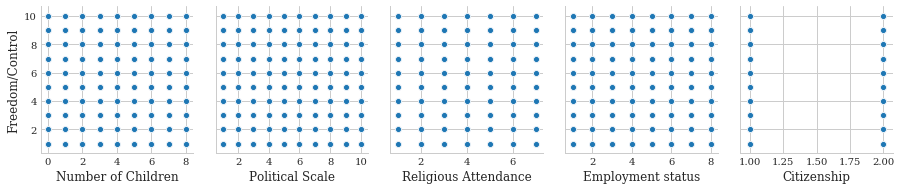

In [10]:
sns.pairplot(data=wv, y_vars=['Freedom/Control'], x_vars=['Number of Children', 'Political Scale', 'Religious Attendance', 'Employment status', 'Citizenship'])

In [11]:
# First, scale the predictors and predicted variables:
Xp=preprocessing.scale(wv[['Number of Children', 'Political Scale', 'Religious Attendance', 'Employment status', 'Citizenship']]).astype('float64')
Yp=preprocessing.scale(wv['Freedom/Control']).astype('float64')#scaling

In [12]:
# Set aside a portion (e.g., 25%) of data for out-of-training-sample testing.

X3p_train, X3p_test, Y3p_train, Y3p_test = train_test_split(Xp, Yp, \
                                                            test_size=0.25, random_state=7)
print(X3p_train.shape, Y3p_train.shape)
print(X3p_test.shape, Y3p_test.shape)

(45735, 5) (45735,)
(15246, 5) (15246,)


In [14]:
# Define the KNN model parameters
knn_rcv = KNeighborsRegressor(n_neighbors=25, weights='uniform') 
# use 25 nearest neighbors weighted uniformly

In [15]:
# fit the KNN model using training sample
knn_rcv.fit(X3p_train, Y3p_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                    weights='uniform')

In [16]:
# how does the model perform in training?
knn_prediction_reg=knn_rcv.predict(X3p_train) 
#get the predictions using training data

In [17]:
np.sqrt(np.square(Y3p_train-knn_prediction_reg).mean()) 
#average error of prediction in training data.

0.96733458236475

In [18]:
import statsmodels.api as sm
sm.tools.eval_measures.rmse(Y3p_train, knn_prediction_reg, axis=0)

0.96733458236475

In [19]:
# We can also use this handy function from the DMBA package to print all the metrics in one go.
regressionSummary(Y3p_train, knn_prediction_reg)


Regression statistics

                      Mean Error (ME) : 0.0022
       Root Mean Squared Error (RMSE) : 0.9673
            Mean Absolute Error (MAE) : 0.7695
          Mean Percentage Error (MPE) : 93.3010
Mean Absolute Percentage Error (MAPE) : 136.0830
